In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [94]:
import minde.benchmark
import minde_c.benchmark
from gen_data import *

In [95]:
torch.cuda.set_device(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

torch.cuda.empty_cache()

device

device(type='cuda')

# Model

In [96]:
class Diffusion(torch.nn.Module):
    def __init__(self, denoiser, mode, loss=None, T=5, device="cuda"):
        super().__init__()
        
        self.denoiser = denoiser
        self.mode = mode
        self.loss = loss
        self.T = T
        self.device = device
        
        if self.loss is None:
            self.loss = torch.nn.MSELoss()

    def apply_noise(self, x: torch.Tensor, z: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        return p * x + torch.sqrt(1.0 - p**2) * z

    def get_denoising_loss(self, X: list[torch.Tensor], idx: int) -> torch.Tensor: 
        batch_size = X[0].shape[0]
        total_dim = sum([x.shape[1] for x in X])
        
        t = torch.rand((batch_size,), device=self.device) * self.T
        p = torch.exp(-t)
        
        if self.mode == "conditional":
            z = torch.randn((batch_size, 1), device=self.device)
        
            # c == 0 -- marginal
            # c == 1 -- conditional 
            cond = int(np.random.random() > 0.5)
            c = cond * torch.ones((batch_size, 1), device=self.device)

            x_noisy = self.apply_noise(X[idx].to(device), z, p[:, None])
        
            if cond == 0:  # marginal
                X_input = []
                for i, x in enumerate(X):
                    if i == idx:
                        X_input.append(x_noisy)
                    else:
                        X_input.append(torch.randn_like(x, device=self.device))
                        
                z_pred = self.denoiser(torch.cat(X_input, dim=1), p[:, None], c)
                
            else:  # conditional
                X_input = []
                for i, x in enumerate(X):
                    if i == idx:
                        X_input.append(x_noisy)
                    else:
                        X_input.append(X[i].to(device))
                        
                z_pred = self.denoiser(torch.cat(X_input, dim=1), p[:, None], c)

        elif self.mode == "joint":
            z = torch.randn((batch_size, total_dim), device=self.device)
            c = torch.ones((batch_size, 1), device=self.device)
            x_noisy = self.apply_noise(torch.cat(X, dim=1).to(device), z, p)    
            z_pred = self.denoiser(x_noisy, p[:, None], c)
        
        return self.loss(z_pred, z)

    def sample(self, z: torch.Tensor, p_schedule: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        # \overline{\alpha}_t = p_t^2
        # \overline{\alpha}_t = \prod_{s=1}^t \alpha_s
        # \alpha_s = 1 - \beta_s
        # \sigma_t^2 = \beta_t \frac{1 - \overline{\alpha}_{t-1}}{1 - \overline{\alpha}_t}

        overline_alpha = p_schedule**2
        alpha = overline_alpha[1::] / overline_alpha[:-1:]
        beta = 1.0 - alpha
        sigma = torch.sqrt(beta * (1.0 - overline_alpha[:-1:]) / (1.0 - overline_alpha[1::]))

        x = z

        for step in range(1, p_schedule.shape[0]):
            z_pred = self.denoiser(x, p_schedule[-step].repeat(x.shape[0])[:, None], c)
            
            x = (x - z_pred * beta[-step] / torch.sqrt(1.0 - overline_alpha[-step])) / torch.sqrt(alpha[-step])
            x += sigma[-step] * torch.randn(x.shape, device=x.device)

        return x

    def forward(self, X: list[torch.Tensor], idx: int) -> torch.Tensor:
        # mode \in {conditional, joint}
        return self.get_denoising_loss(X, idx)

In [97]:
class ResidualBlock(nn.Module):
    def __init__(self, dim: int, dropout: float = 0.2):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        out = self.act(self.fc1(x))
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.act(out + residual) 
        return out


class ConditionalMLPDenoiser(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 512, num_blocks: int = 3, dropout: float = 0.2):
        super().__init__()

        self.input_layer = nn.Linear(input_dim, hidden_dim)

        self.blocks = nn.ModuleList([ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)])

        self.output_layer = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.LeakyReLU()

    def forward(self, x: torch.Tensor, p: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        # p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        # c = c.reshape((c.shape[0],) + (1,) * (len(x.shape) - 1))
        x_p = torch.cat([x, p, c], dim=-1)

        out = self.activation(self.input_layer(x_p))
        for block in self.blocks:
            out = block(out)
        out = self.output_layer(out)
        return out

# Train

In [98]:
def draw_loss(losses, val_losses):
    plt.plot(losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss over time")
    plt.legend()
    plt.show()

In [99]:
def val(
    model,
    val_dataloader,
    val_losses,
    idx=None
):
    model.eval()
    with torch.no_grad():
        sum_loss = 0
        for batch in val_dataloader:
            loss = model(batch, idx) 
            sum_loss += loss.item()
            
        val_losses.append(sum_loss / len(val_dataloader))

In [100]:
def train(
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    n_epochs,
    idx=None,
):
    step = 0
    losses = []
    val_losses = []
    
    for epoch in trange(n_epochs):
        model.train()
        sum_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()    
            loss = model(batch, idx)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            step += 1
        
        losses.append(sum_loss / len(train_dataloader))
        
        val(model, val_dataloader, val_losses, idx)
        clear_output(wait=True)
        draw_loss(losses, val_losses)
        tqdm.write(f"Epoch [{epoch+1}/{n_epochs}], Step [{step}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

In [101]:
class MultiTensorDataset(Dataset):
    def __init__(self, tensors):
        self.tensors = tensors
        self.N = tensors[0].shape[0]
        for t in tensors:
            assert t.shape[0] == self.N, "All tensors must have same number of samples"

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return [t[idx] for t in self.tensors]


def collate_fn(batch):
    batch = list(zip(*batch))
    return [torch.stack(tensors, dim=0) for tensors in batch]

In [102]:
def random_covariance_matrix(n):
    A = torch.randn(n, n)
    cov = A @ A.T
    d = torch.sqrt(torch.diag(cov))
    cov = cov / (d.unsqueeze(0) * d.unsqueeze(1))
    return cov

def create_randomly_correlated_normal_data(n_samples, n_dim):
    mean = torch.zeros(n_dim)
    cov = random_covariance_matrix(n_dim)

    joint = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    dep_data = joint.sample((n_samples,))
    
    return dep_data, cov    

In [105]:
n_samples = 100_000
n_epochs = 200
n_dim = 3
r = 0.7

# cov = torch.tensor([
#     [1, 0, 0.7],
#     [0, 1, 0],
#     [0.7, 0, 1]
# ])
# joint = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0, 0.0]), covariance_matrix=cov)
# dep_data = joint.sample((n_samples,))


dep_data, cov = create_randomly_correlated_normal_data(n_samples, n_dim)

dep_data, dep_data_val = dep_data[:int(n_samples * 0.9)], dep_data[int(n_samples * 0.9):]

dep_data = [dep_data[:, i].unsqueeze(1) for i in range(0, n_dim)]
dep_data_val = [dep_data_val[:, i].unsqueeze(1) for i in range(0, n_dim)]

train_dataset = MultiTensorDataset(dep_data)
val_dataset = MultiTensorDataset(dep_data_val)

dep_train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, collate_fn=collate_fn)
dep_val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True, collate_fn=collate_fn)

In [108]:
conditional_models = []
conditional_optimizers = []
for i in range(n_dim):
    model = Diffusion(ConditionalMLPDenoiser(input_dim=n_dim + 2, output_dim=1), device=device, mode="conditional").to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    conditional_models.append(model)
    conditional_optimizers.append(optimizer)
    
model_joint = Diffusion(ConditionalMLPDenoiser(input_dim=n_dim + 2, output_dim=n_dim), device=device, mode="joint").to(device)
optimizer_joint = torch.optim.Adam(model_joint.parameters(), lr=5e-4)

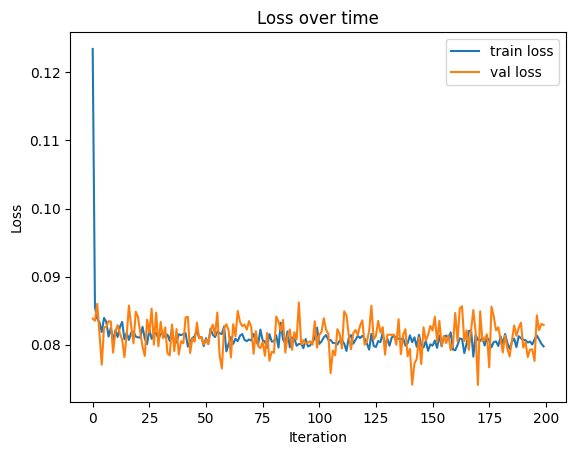

100%|██████████| 200/200 [04:40<00:00,  1.40s/it]

Epoch [200/200], Step [17600/88], Loss: 0.0858


In [109]:
train(model_joint, optimizer_joint, dep_train_dataloader, dep_val_dataloader, n_epochs)

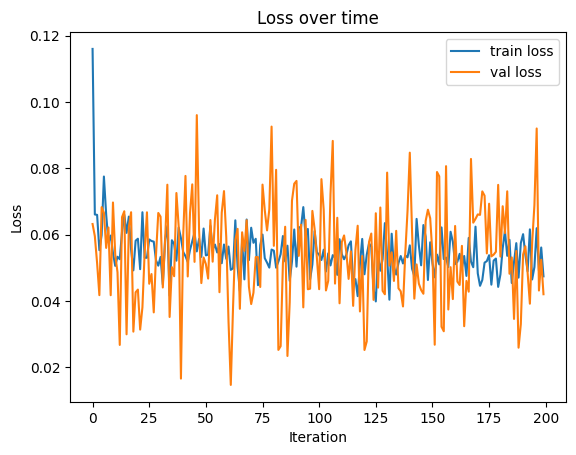


100%|██████████| 3/3 [12:57<00:00, 259.03s/it]

Epoch [200/200], Step [17600/88], Loss: 0.0065


In [110]:
for i in tqdm(range(n_dim)):
    train(conditional_models[i], conditional_optimizers[i], dep_train_dataloader, dep_val_dataloader, n_epochs, idx=i)

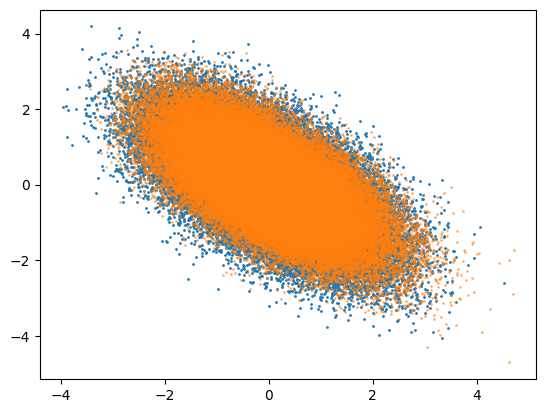

In [114]:
z = torch.randn((100_000, n_dim), device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0).unsqueeze(1)
c = torch.ones((100_000, 1), device=device)

# print(z.shape, p_schedule.shape, c.shape)

model_joint.eval()
with torch.no_grad():
    sampled = model_joint.sample(z, p_schedule, c)
    
plt.scatter(dep_data[0].numpy(), dep_data[2].numpy(), s=1)
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,2].cpu().numpy(), alpha=0.5, s=1)

# O-information for 1d RVs

In [115]:
def entropy_mvn(cov):
    if len(cov.shape) == 1:
        cov = cov.unsqueeze(0)
    k = cov.shape[-1]
    sign, logdet = torch.linalg.slogdet(cov)
    entropy = 0.5 * (k * (1 + torch.log(torch.tensor(2 * torch.pi))) + logdet)
    return entropy


def O_information_mvn3(cov):
    O_inf = 0
    O_inf += entropy_mvn(cov[0, 0].unsqueeze(0)) + entropy_mvn(cov[1, 1].unsqueeze(0)) + entropy_mvn(cov[2, 2].unsqueeze(0))
    O_inf -= entropy_mvn(cov[0:2, 0:2]) + entropy_mvn(cov[1:3, 1:3]) + entropy_mvn(torch.tensor([[cov[0][0], cov[0][2]], [cov[2][0], cov[2][2]]]))
    O_inf += entropy_mvn(cov)
    
    return O_inf

In [117]:
def score_func(model, X_t, t, c, device="cuda"):
    p = torch.exp(-t)
    X_t = X_t.to(device)
    p = p.to(device)
    c = c.to(device)
    
    # p = p.reshape((p.shape[0],) + (1,) * (len(X_t.shape) - 1))
    # c = c.reshape((c.shape[0],) + (1,) * (len(X_t.shape) - 1))

    EPS = 1e-12
    safe = torch.clamp(1 - p**2, min=EPS)
    denom = torch.sqrt(safe)
    
    score = -model.denoiser(X_t, p, c).detach() / denom
    return score


def calc_marginal_scores(conditional_models, X_batch, batch_size, t, z, N, device):
    scores_marginal = []
    
    for i in range(N):
        X_idx = []
                
        for j in range(N):
            if i == j:
                std = torch.sqrt(torch.clamp(1 - torch.exp(-2 * t), min=1e-12))
                X_t = torch.exp(-t) * X_batch[j].to(device) + std * z
                X_idx.append(X_t)
            else:
                X_idx.append(torch.randn_like(X_batch[j], device=device))
                
        c = torch.zeros((batch_size, 1), device=device)
        score = score_func(conditional_models[i], torch.cat(X_idx, dim=1), t, c, device)
        
        scores_marginal.append(score)
        
    scores_marginal = torch.cat(scores_marginal, dim=1)
    return scores_marginal


def calc_conditional_scores(conditional_models, X_batch, batch_size, t, z, N, device):
    scores_conditional = []
    
    for i in range(N):
        X_idx = []
                
        for j in range(N):
            if i == j:
                std = torch.sqrt(torch.clamp(1 - torch.exp(-2 * t), min=1e-12))
                X_t = torch.exp(-t) * X_batch[j].to(device) + std * z
                X_idx.append(X_t)
            else:
                X_idx.append(X_batch[j].to(device))
                
        c = torch.ones((batch_size, 1), device=device)
        score = score_func(conditional_models[i], torch.cat(X_idx, dim=1), t, c, device)
        
        scores_conditional.append(score)
        
    scores_conditional = torch.cat(scores_conditional, dim=1)
    return scores_conditional


def estimate_O_information(
    conditional_models,
    model_joint,
    X,
    batch_size=100_000,
    iters_per_point=10,
    dt=0.01,
    T=5,
    device="cuda"
):
    
    for i in range(len(conditional_models)):
        conditional_models[i].eval()
    model_joint.eval()
    
    N = len(X)
    Omega = []
    
    t_range = np.arange(2 * dt, T, step=dt)
    
    for i in trange(len(t_range) - 1):
        t, dt = torch.tensor(t_range[i]), t_range[i + 1] - t_range[i]
        t = t * torch.ones((batch_size, 1), device=device)
        
        omega_sum = 0
        
        for _ in range(iters_per_point):
            z = torch.randn((batch_size, 1), device=device)
            idx = np.random.randint(0, X[0].shape[0], batch_size)
            X_batch = [x[idx, :] for x in X]
            
            scores_marginal = calc_marginal_scores(conditional_models, X_batch, batch_size, t, z, N, device)
            scores_conditional = calc_conditional_scores(conditional_models, X_batch, batch_size, t, z, N, device)
            
            X_t = torch.cat(X_batch, dim=1).to(device)
            X_t = torch.exp(-t) * X_t + torch.sqrt(1 - torch.exp(-2 * t)) * z
            c = torch.ones((batch_size, 1), device=device)
            scores_joint = score_func(model_joint, X_t, t, c, device)
            
            T_x = 0.5 * torch.mean(torch.sum((scores_joint - scores_marginal)**2, dim=1))
            D_x = 0.5 * torch.mean(torch.sum((scores_joint - scores_conditional)**2, dim=1))
            
            omega_sum += (T_x - D_x).cpu().item()
        
        Omega.append(omega_sum / iters_per_point)
        
    return Omega, np.sum(Omega) * dt

In [119]:
Omega_steps, O_inf = estimate_O_information(conditional_models, model_joint, dep_data, dt=0.01, iters_per_point=1)

100%|██████████| 498/498 [02:38<00:00,  3.13it/s]


-1.4167645066756314


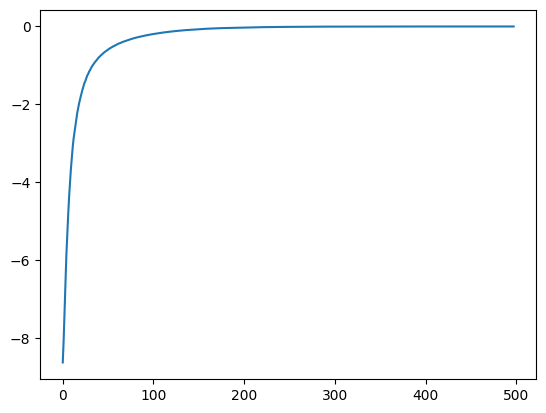

In [121]:
print(O_inf)

plt.plot(Omega_steps)
plt.show()

In [120]:
O_information_mvn3(cov).item()

-1.3938360214233398

In [74]:
cov

tensor([[ 1.0000,  0.6018, -0.2790],
        [ 0.6018,  1.0000, -0.9079],
        [-0.2790, -0.9079,  1.0000]])